##Importing 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(42)  # 무조건 42로 세팅!!

In [2]:
!pip install xgboost

In [3]:
from xgboost import XGBClassifier

##파일 불러오기

In [158]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
submission = pd.read_csv("/content/sample_submission.csv")
print(train.shape, test.shape, submission.shape)

(48199, 13) (7695, 12) (7695, 2)


##데이터 이해하기


###OK(1)click_id, (2)date는 전혀 Clicked에 영향을 주는 feature가 아님--> drop
###OK(3)order와 (5)sessionID는 유사한 정보를 주는 feature인듯 하여, 하나(order)는 drop시키는게 더 효율적일 것으로 생각됨/ sessionID는 하나의 유저임을 알 수 있는 정보
###(4)country--> hint로 이용해보라고 하심(나라별로 존재하는 특징을 사용하기) --> main category와 연결해서 데이터를 관찰하면, 12번에 해당하는 국가의 경우만, main category가 결측값이다.
###OK(6)main category와 (7)clothing model은 결측치 대체 과정이 필요함--> clothing model은 main category + location + page + model photography의 정보를 조합하면 만들어낼 수 있음/ --> main category의 결측값은 clothing model을 이용해서 채울 수 있을 것으로 보인다.
-->clothing model은 drop하자
###OK(8)colour-색깔별로 click O,X의 비율이 다름 --> 비슷한 비율을 가진 색끼리 조합해보면, [1,5,6,12],[9,10,11,13],[4,7,14],[2,3,8]순서대로 비율이 낮다. --> 순서를 가지고 있다고 생각할 수 있기 때문에 위의 조합대로 나눈 후, ordinal encoding 하자.
###OK(9)location --> 그룹으로 묶으니까 오히려 성능이 떨어짐
###(11)page --> 그대로 두어도 될 것 같은 feature.
###(12)price --> 그룹으로 묶으니까 오히려 성능이 떨어짐


In [65]:
train

click_id        date  order  country  session ID  \
0             1  2024-04-01      1       29           1   
1             2  2024-04-01      2       29           1   
2             3  2024-04-01      3       29           1   
3             4  2024-04-01      4       29           1   
4             5  2024-04-01      5       29           1   
...         ...         ...    ...      ...         ...   
48194     48195  2024-04-30     38       29        6940   
48195     48196  2024-04-30     39       29        6940   
48196     48197  2024-04-30     40       29        6940   
48197     48198  2024-04-30     41       29        6940   
48198     48199  2024-04-30      1       29        6941   

       page 1 (main category) page 2 (clothing model)  colour  location  \
0                         1.0                     A13       1         5   
1                         1.0                     A16       1         6   
2                         2.0                      B4      10         2   
3                         2.0                     B17       6         6   
4                         2.0                      B8       4         3   
...                       ...                     ...     ...       ...   
48194                     2.0                     B33       6         5   
48195                     2.0                     B34       2         6   
48196                     4.0                      P4       4         2   
48197                     4.0                     P74      12         1   
48198                     1.0                      A4       3         2   

       model photography  page  price  Clicked  
0                      1     1   39.0        1  
1                      1     1   40.0        0  
2                      1     1   46.0        1  
3                      2     1   30.0        0  
4                      2     1   41.0        0  
...                  ...   ...    ...      ...  
48194                  2     2   39.0        0  
48195                  1     2   46.0        0  
48196                  1     1   49.0        1  
48197                  2     5   49.0        0  
48198                  2     1   45.0        0  

[48199 rows x 13 columns]

In [66]:
train.isnull().sum()    # page1 : 31개, page2 : 2135개

click_id                      0
date                          0
order                         0
country                       0
session ID                    0
page 1 (main category)       31
page 2 (clothing model)    2135
colour                        0
location                      0
model photography             0
page                          0
price                         0
Clicked                       0
dtype: int64

<Axes: ylabel='count'>

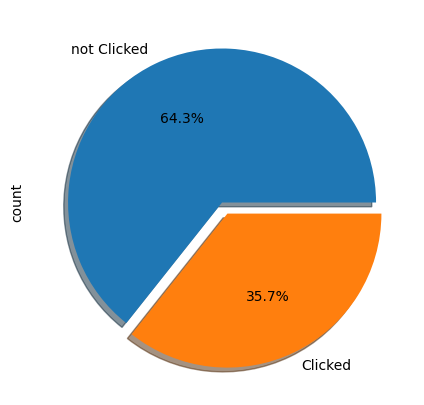

In [18]:
#즉, 클릭하지 않은 횟수가 거의 두 배에 달할 정도로 많음
train["Clicked"].value_counts()

plt.figure(figsize=(8, 5))
labels = ['not Clicked', 'Clicked']
train['Clicked'].value_counts().plot.pie(explode=[0, 0.08],
                                          shadow=True,
                                          autopct='%1.1f%%',
                                          labels=labels)

###colour에 대한 그래프

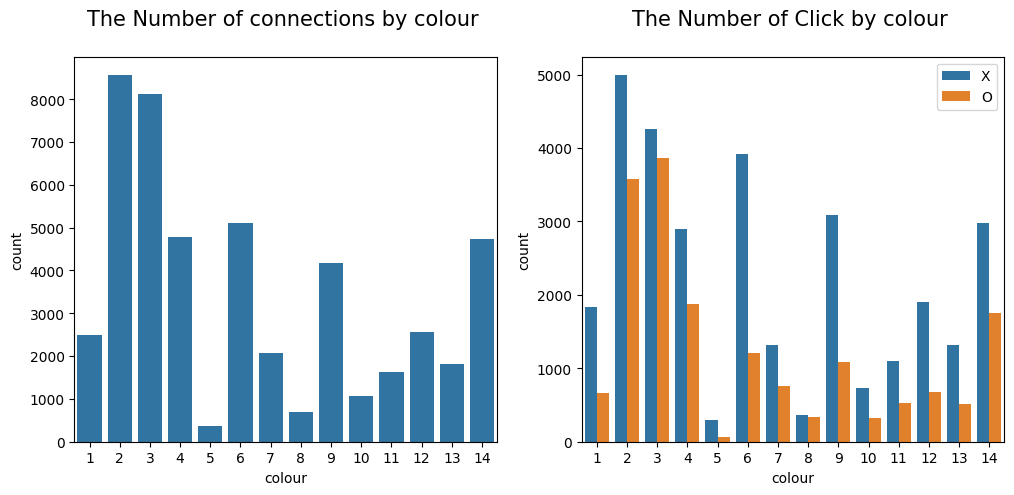

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title("The Number of connections by colour \n", size=15)
sns.countplot(data=train, x='colour', ax=axes[0])

axes[1].set_title("The Number of Click by colour \n", size=15)
sns.countplot(x="colour", hue="Clicked", data=train, ax=axes[1])
axes[1].legend(labels = ['X', 'O'])

###location에 대한 그래프

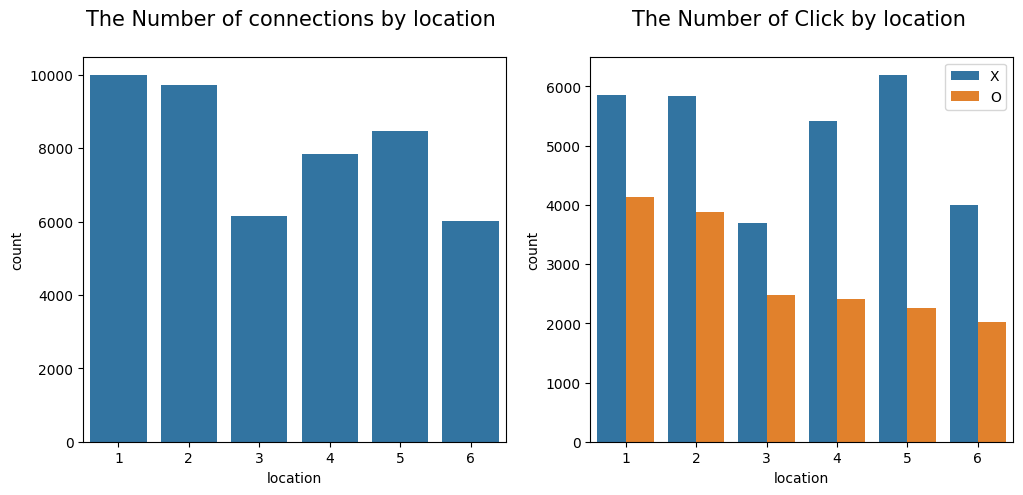

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title("The Number of connections by location \n", size=15)
sns.countplot(data=train, x='location', ax=axes[0])

axes[1].set_title("The Number of Click by location \n", size=15)
sns.countplot(x="location", hue="Clicked", data=train, ax=axes[1])
axes[1].legend(labels = ['X', 'O'])

###model photograpy에 대한 그래프

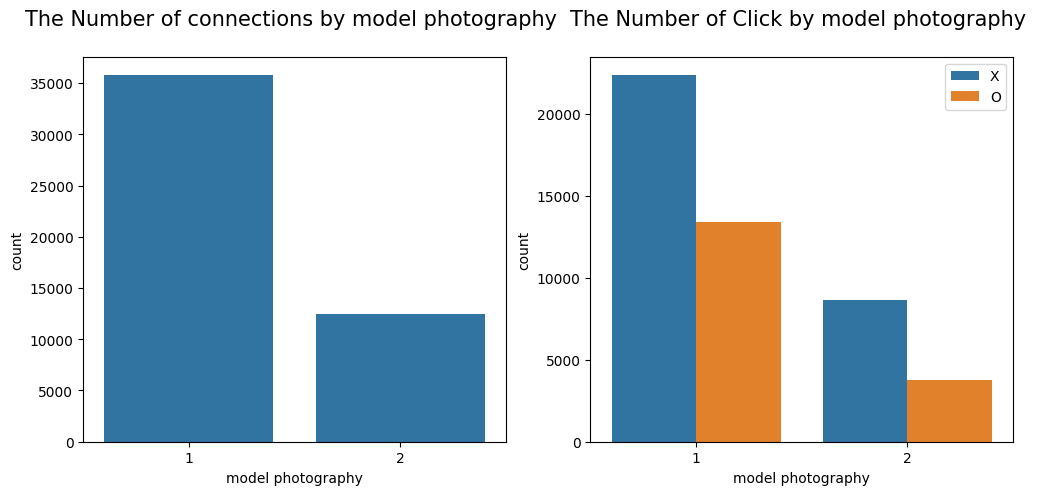

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title("The Number of connections by model photography \n", size=15)
sns.countplot(data=train, x='model photography', ax=axes[0])

axes[1].set_title("The Number of Click by model photography \n", size=15)
sns.countplot(x="model photography", hue="Clicked", data=train, ax=axes[1])
axes[1].legend(labels = ['X', 'O'])

###price에 대한 그래프

<Axes: xlabel='price', ylabel='Density'>

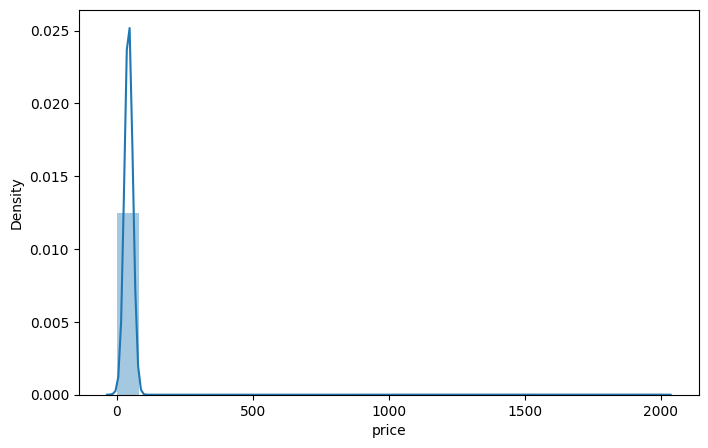

In [27]:
plt.figure(figsize=(8, 5))
sns.distplot(train['price'], bins=25)

<Axes: xlabel='price', ylabel='Density'>

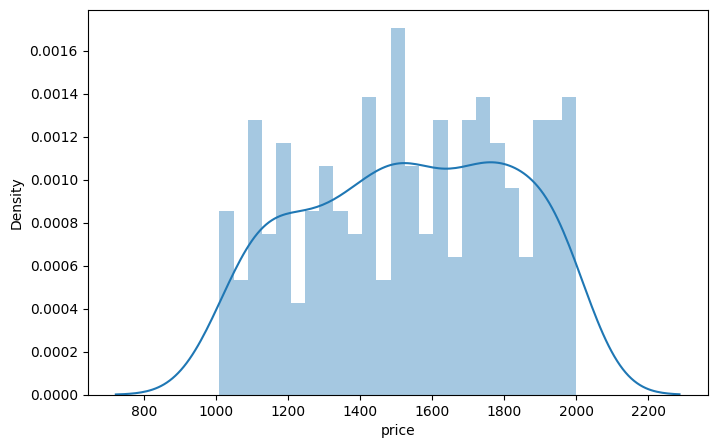

In [43]:
plt.figure(figsize=(8, 5))
sns.distplot(train[train['price']>700]['price'], bins=25)

<Axes: xlabel='price', ylabel='Density'>

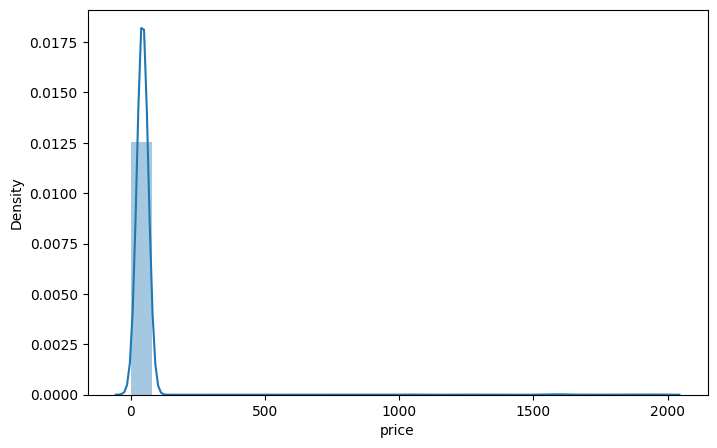

In [28]:
plt.figure(figsize=(8, 5))
sns.distplot(test['price'], bins=25)

<Axes: xlabel='price', ylabel='Density'>

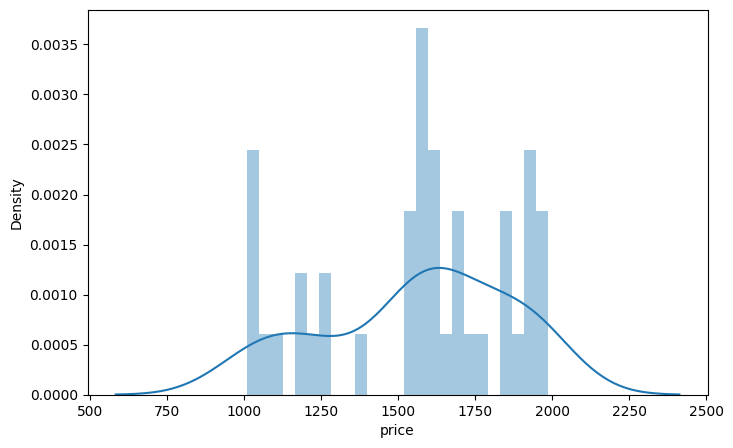

In [29]:
plt.figure(figsize=(8, 5))
sns.distplot(test[test['price']>500]['price'], bins=25)

##데이터 전처리

###[main category 결측치 채우기]-(6)

In [159]:
#main category 결측치 채우기 --> by clothing model의 앞 문자(A:1.0, B:2.0, C:3.0, P:4.0)
mask = (train["country"] == 12) &  (train["page 1 (main category)"].isna()) #& (train["page 2 (clothing model)"].notna())

# page 2 (clothing model)의 첫 번째 문자 가져와서 매핑 (A -> 1.0, B -> 2.0, C -> 3.0, P -> 4.0)
mapping = {'A': 1.0, 'B': 2.0, 'C': 3.0, 'P': 4.0}

# 변환 적용
train.loc[mask, "page 1 (main category)"] = train.loc[mask, "page 2 (clothing model)"].str[0].map(mapping)

# 변환이 적용된 데이터 개수 확인
print(train.loc[mask, ["page 1 (main category)", "page 2 (clothing model)"]].dropna().shape[0])

31


###[colour에 따라 나누기]-(8)

In [160]:
# 색상 그룹 매핑 (높은 Click 비율 → 낮은 숫자)
color_map = {
    2: 0, 3: 0, 8: 0,  # 가장 높은 Click 비율 (가장 낮은 숫자)
    4: 1, 7: 1, 14: 1,  # 두 번째 그룹
    9: 2, 10: 2, 11: 2, 13: 2,  # 세 번째 그룹
    1: 3, 5: 3, 6: 3, 12: 3  # 가장 낮은 Click 비율 (가장 높은 숫자)
}

# colour 컬럼 변환
train["colour"] = train["colour"].map(color_map)

###시간에 따른 정보 추출

In [144]:
#train["dayofweek"] = pd.to_datetime(train["date"]).dt.dayofweek  # 0=월, 6=일

###price 로그변환

In [107]:
#train["price_log"] = np.log1p(train["price"])  # log1p(1 + x) -> log(0) 방지

###[click_id, date, order, page 2 (clothing model) 드랍시키기]-(1),(2),(3),(5),(7)

In [161]:
train = train.drop(["click_id", "date", "order", "page 2 (clothing model)"], axis=1)

##학습하기
-XGboost 모델 사용하기
-하이퍼파라미터의 영향을 많이 받는 모델이기에 최적의 조합 찾기

In [162]:
X = train.drop('Clicked', axis=1)
y = train['Clicked']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(38559, 8) (9640, 8) (38559,) (9640,)


In [36]:
clf = XGBClassifier()
params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
}
grid = GridSearchCV(clf, param_grid=params, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)
print("Best Parameters: ", grid.best_params_)
print("Best Score: ", grid.best_score_)

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Score:  0.6737987703883712


In [37]:
clf2 = XGBClassifier()
params2 = {
    'n_estimators': [100, 125, 150],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1, 0.15],
    'subsample': [0.8, 0.9],
    'min_child_weight': [1, 3, 5]
}
grid2 = GridSearchCV(clf2, param_grid=params2, scoring='accuracy', cv=5)
grid2.fit(X_train, y_train)
print("Best Parameters: ", grid2.best_params_)
print("Best Score: ", grid2.best_score_)

Best Parameters:  {'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Best Score:  0.6738247073615264


In [100]:
#xgb_clf = XGBClassifier(**grid.best_params_) #과적합 많이 생김
#xgb_clf = XGBClassifier(**grid2.best_params_)
xgb_clf = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=150, subsample=0.8, min_child_weight=3)
xgb_clf.fit(X_train, y_train)

train_pred = xgb_clf.predict(X_train)
val_pred = xgb_clf.predict(X_val)

In [101]:
feature_importance = pd.DataFrame(xgb_clf.feature_importances_.reshape((1, -1)), columns=X_train.columns, index=['feature_importance'])
feature_importance

country  session ID  page 1 (main category)   colour  \
feature_importance  0.019643    0.020092                0.205565  0.34571   

                    location  model photography      page     price  \
feature_importance  0.100854           0.093604  0.137252  0.038489   

                    dayofweek  price_log  
feature_importance   0.015874   0.022916

In [177]:
#[0.6798-0.6682]/[0.6786-0.6683]
xgb_clf = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=150, subsample=0.81, min_child_weight=3)
xgb_clf.fit(X_train, y_train)

train_pred = xgb_clf.predict(X_train)
val_pred = xgb_clf.predict(X_val)

print("Train ACC : %.4f" % accuracy_score(y_train, train_pred))
print("Val ACC : %.4f" % accuracy_score(y_val, val_pred))

Train ACC : 0.6791
Val ACC : 0.6695


In [ ]:
#
xgb_clf = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=170, subsample=0.8, min_child_weight=3)
xgb_clf.fit(X_train, y_train)

train_pred = xgb_clf.predict(X_train)
val_pred = xgb_clf.predict(X_val)

print("Train ACC : %.4f" % accuracy_score(y_train, train_pred))
print("Val ACC : %.4f" % accuracy_score(y_val, val_pred))

[date 정보O]

Train ACC : 0.6792

Val ACC : 0.6687

[date 정보X]

Train ACC : 0.6786

Val ACC : 0.6683

[price log변환O]

Train ACC : 0.6797

Val ACC : 0.6680

##Test data에 대해 동일 과정 반복

In [178]:
#main category 결측치 채우기 --> by clothing model의 앞 문자(A:1.0, B:2.0, C:3.0, P:4.0)
mask = (test["country"] == 12) &  (test["page 1 (main category)"].isna())
# page 2 (clothing model)의 첫 번째 문자 가져와서 매핑 (A -> 1.0, B -> 2.0, C -> 3.0, P -> 4.0)
mapping = {'A': 1.0, 'B': 2.0, 'C': 3.0, 'P': 4.0}
# 변환 적용
test.loc[mask, "page 1 (main category)"] = test.loc[mask, "page 2 (clothing model)"].str[0].map(mapping)
# 변환이 적용된 데이터 개수 확인
print(test.loc[mask, ["page 1 (main category)", "page 2 (clothing model)"]].dropna().shape[0])

3


In [179]:
# 색상 그룹 매핑 (높은 Click 비율 → 낮은 숫자)
color_map = {
    2: 0, 3: 0, 8: 0,  # 가장 높은 Click 비율 (가장 낮은 숫자)
    4: 1, 7: 1, 14: 1,  # 두 번째 그룹
    9: 2, 10: 2, 11: 2, 13: 2,  # 세 번째 그룹
    1: 3, 5: 3, 6: 3, 12: 3  # 가장 낮은 Click 비율 (가장 높은 숫자)
}
# colour 컬럼 변환
test["colour"] = test["colour"].map(color_map)

In [139]:
#test["price_log"] = np.log1p(test["price"])  # log1p(1 + x) -> log(0) 방지

In [133]:
#test["dayofweek"] = pd.to_datetime(test["date"]).dt.dayofweek  # 0=월, 6=일

In [180]:
test = test.drop(["click_id", "date", "order", "page 2 (clothing model)"], axis=1)

In [181]:
test

country  session ID  page 1 (main category)  colour  location  \
0           9        6942                     3.0       2         2   
1           9        6943                     3.0       3         1   
2           9        6943                     3.0       1         2   
3           9        6943                     3.0       2         2   
4           9        6943                     3.0       3         4   
...       ...         ...                     ...     ...       ...   
7690       29        8086                     4.0       1         5   
7691       29        8086                     4.0       0         1   
7692       29        8086                     4.0       1         3   
7693       29        8086                     4.0       3         4   
7694       29        8086                     4.0       1         2   

      model photography  page  price  
0                     1     1   56.0  
1                     1     1   54.0  
2                     2     3   33.0  
3                     1     3   36.0  
4                     1     3   29.0  
...                 ...   ...    ...  
7690                  2     1   39.0  
7691                  1     2   46.0  
7692                  1     5   35.0  
7693                  2     5   43.0  
7694                  2     5   45.0  

[7695 rows x 8 columns]

In [182]:
X_test = test

output = xgb_clf.predict(X_test)
assert len(output) == 7695  # sanity check

##submission.csv 생성

In [183]:
submission['Clicked'] = output
submission.to_csv('submission.csv', index=False)